# MagGeo - Guideline Notebook

This notebook demonstrates how to annotate GPS trajectories with geomagnetic data using the MagGeo library (PyPI version).

## Prerequisites

Before running this notebook, you need a **VirES token** to access Swarm satellite data:

1. Go to [https://vires.services/](https://vires.services/)
2. Create an account (it's free)
3. Go to your account settings 
4. Generate a new token
5. Copy the token and paste it in the `params` dictionary below


# How to run MagGeo

First you need to install the required packages and import the necessary libraries. Then, you can create a `MagGeo` instance with your parameters and run the analysis.
```python
# Install the required packages
pip install maggeo  


## 1. Import Libraries
Import MagGeo and other required libraries.

In [ ]:
from maggeo.core import annotate_gps_with_geomag

Here, MagGeo include trajectory files (data/sample_data) with the required attributes that usually are included. The `annotate_gps_with_geomag` function will annotate the GPS data with geomagnetic indices, including the AE and SME indices if available.

```python
# Import necessary libraries
import os
from maggeo.core import annotate_gps_with_geomag

## 2. Set Up Parameters
Specify the gps trajectory dataset, column names and other parameters as required by your data.

In [ ]:
# Set your token as environment variable (recommended)
import os
os.environ['VIRES_TOKEN'] = "3b5qyp3aNoVB9FEBEnKgrePoQtQhMUD-"  # Replace with your actual token

# 2. Set up parameters for MagGeo
params = {
    "data_dir": os.path.join(os.getcwd(), "data", "sample_data"),
    "gpsfilename": "BirdGPSTrajectoryTest.csv",  # or your test file
    "lat_col": "location-lat",
    "long_col": "location-long",
    "datetime_col": "timestamp",
    "altitude_col": "height",  # or "" if not present
    "token": os.environ.get('VIRES_TOKEN'),  # Get token from environment
    # Enhanced SwarmDataManager settings
    "use_swarm_manager": True,
    "swarm_data_dir": "temp_data/swarm_data",
    "swarm_file_format": "csv",
    "resume_swarm_download": True
}

## 3. Annotate GPS Trajectory
Run the MagGeo annotation process. This may take a few minutes depending on data size.

In [ ]:
 # Now run the annotation process
print("Starting MagGeo processing...")

# This will annotate the GPS trajectory using the enhanced SwarmDataManager
# Token is now cached and won't show "Token saved" multiple times
# Progress bar shows a clean, unified view of the download process
result_df = annotate_gps_with_geomag(
    params,
    use_swarm_manager=True,  # Use improved SwarmDataManager
    use_parallel=False       # Set to True for parallel processing if desired
)

print(" MagGeo processing completed successfully")
        
# Display results
print(f"Result shape: {result_df.shape}")
display(result_df.head())

## 4. Saving/Exporting the results

You can save the annotated DataFrame to CSV or continue with your analysis.

In [ ]:
%%time
# Save the results
outputfile =params["gpsfilename"].replace(".csv", "_annotated.csv")
output_path = os.path.join("data/results", outputfile)
result_df.to_csv(output_path)
print(f"\nResults saved to: {output_path}")


## 5. Validate the results
To validate the results we plot the `F`column. Intensity of the geomagnetic field in nanoTesla (nT) and compare it with the expected values. This is useful to ensure that the data has been correctly annotated and that the geomagnetic indices are accurate.


In [ ]:
import matplotlib.pyplot as plt
## Creating a copy of the results and setting the Datetime Column as dataframe index.
ValidateDF = result_df.copy()
ValidateDF.set_index("timestamp", inplace=True)
## Plotting the F column.
hist = ValidateDF.hist(column='F')
plt.title('F distribution')
plt.xlabel('F in nT')
plt.ylabel('# of measurements')

## 6. Map the GPS Track using the annotated Magnetic Values

Now we are going to plot the annotated GPS trajectory to see the different magnetic components in a map and have a better perspective of the impact of the earth magnetic field over the trajectory.

In [ ]:
ValidateDF.plot(kind="scatter", x="location-lat", y="location-long",
    label="Magnetic Intensity in nT",
    c="F", cmap=plt.get_cmap("gist_rainbow"),
    colorbar=True, alpha=0.4, figsize=(10,7),
    sharex=False #This is only needed to get the x-axis label working due to a current bug in pandas plot.
    
)

plt.ylabel("Longitude", fontsize=12)
plt.xlabel("Latitude", fontsize=12)
plt.legend(fontsize=12)
plt.show()

# MagGeo in debug mode (Advanced)

This is totally optional. Debug mode is useful to see what's happening under the hood. You can enable it by setting the `MAGGEO_DEBUG` environment variable to `True`. This will print additional information about the processing steps.

If debug mode is active, it will:
- Show detailed logging information
- Save intermediate files to `temp_data/` directory so you can have a whole track of the processing

```python
# Enable debug mode to see what's happening
os.environ['MAGGEO_DEBUG'] = 'True'

In [ ]:
# 1. Set up parameters for your test
import os

# Enable debug mode to see what's happening
os.environ['MAGGEO_DEBUG'] = 'True'    

params = {
    "data_dir": os.path.join(os.getcwd(), "data", "sample_data"),
    "gpsfilename": "trajectory_test.csv",  # or your test file
    "lat_col": "location-lat",
    "long_col": "location-long",
    "datetime_col": "timestamp",
    "altitude_col": "height",  # or "" if not present
    "token": os.environ.get('VIRES_TOKEN'),  # Use environment variable
    # SwarmDataManager
    "use_swarm_manager": True,
    "swarm_data_dir": "temp_data/swarm_data",
    "swarm_file_format": "parquet",
    "resume_swarm_download": True,
    "chunk_size": 10  # Process 10 dates at a time
}

print("Debug mode enabled")
print(" Using SwarmDataManager")
print(" Resume functionality enabled")

In [ ]:
# Annotate your trajectory, but now it will now generate debug output and save temp files
result = annotate_gps_with_geomag(params)

# Debug files will be saved to temp_data/:
# - maggeo_debug.log (log file)
# - multiple .csv files with intermediate results.

In [ ]:
%load_ext watermark
%watermark -i -v -p chaosmagpy,numpy,matplotlib,maggeo,scipy,cartopy,viresclient

In [ ]:
## Creating a copy of the results and setting the Datetime Column as dataframe index.
## Plotting the GeoMagmetic columns, F, D, I, H, X, Y, Z
result_df_copy = result_df.copy()
result_df_copy.set_index(result_df_copy['timestamp'], inplace=True)
hist = result_df_copy.hist(column='F')
plt.title('F distribution')
plt.xlabel('F in nT')
plt.ylabel('# of measurements') 
plt.show()

# Including AE and SME indices to your trajectory

MagGeo can also include the AE and SME indices in the analysis. This is useful to understand the geomagnetic activity during the GPS trajectory. You can use `indices` module that contains the functions `get_ae_index()` and `get_sme_index()`. Here is how you can use them:

```python
# Fetching Data from HAPI severs to Include AE indices
from maggeo import indices

First, we need to read the annotated GPS trajectory from MagGeo.

In [ ]:
#import os; print(os.popen('pip install hapiclient --upgrade').read())
#%import os; print(os.popen('pip install hapiplot --upgrade').read())

## Fetching AE indices

AE indices can be fetched from the HAPI server using the `get_ae_index` function. This function will return a DataFrame with the AE indices for the specified dates. 

In [ ]:
# Using get_ae_index() function
from maggeo.indices import get_ae_index
import pandas as pd
import os

# Read your MagGeo results, here I assume you have already annotated your trajectory
# but you can even do it to your trajectory without that. The trajectory needs to be in CSV format
csv_path = os.path.join("data/results", "MagGeoResult.csv")
df_csv = pd.read_csv(csv_path)
df_csv['timestamp'] = pd.to_datetime(df_csv['timestamp'])
df_csv["date"] = df_csv['timestamp'].dt.date.astype(str)

# Get unique dates, to optimize the AE index fetching
# This will reduce the number of requests to the HAPI server
unique_dates = df_csv['date'].unique()

# Fetch AE indices
ae_data = get_ae_index(unique_dates, verbose=False)

print(f"AE data shape: {ae_data.shape}")
print("AE data sample:")
print(ae_data.head())

In [ ]:
# Now you need to Merge AE data with the original trajectory, and MagGeo has a
# function for that.

from maggeo.indices import merge_indices_with_maggeo

df_with_ae = merge_indices_with_maggeo(df_csv, ae_data=ae_data)

# Save results
output_path = os.path.join("data/results", "MagGeoResult_with_AE.csv")
df_with_ae.to_csv(output_path)
print(f"Results with AE indices saved to: {output_path}")

# Display sample
print("\nSample of merged data:")
available_cols = [col for col in ['F', 'AE_INDEX', 'AL_INDEX', 'AU_INDEX'] if col in df_with_ae.columns]
print(df_with_ae[available_cols].head())

## Fetching SME indices
Similarly, you can fetch the SME indices using the `get_sme_index` function. This function will return a DataFrame with the SME indices for the specified dates.


In [ ]:
# Using get_sme_index() function
from maggeo.indices import get_sme_index

# Fetch SME indices
sme_data = get_sme_index(unique_dates, verbose=False)

print(f"SME data shape: {sme_data.shape}")
print("SME data sample:")
print(sme_data.head())

In [ ]:
# Merge SME with original trajectory or MagGeo Results.
df_with_sme = merge_indices_with_maggeo(df_csv, sme_data=sme_data)

print("Dataset with SME indices:")
available_cols = [col for col in ['F', 'SME'] if col in df_with_sme.columns]
print(df_with_sme[available_cols].head())

# Save the dataset
output_path = os.path.join("data/results", "MagGeoResult_with_SME_indices.csv")
df_with_sme.to_csv(output_path)
print(f"\nComprehensive results saved to: {output_path}")

## Identifying unique dates for Swarm data download
You can use the `identify_unique_dates` function to determine the unique dates needed for Swarm data download. This function analyzes the GPS trajectory and returns a list of unique dates that are required for the Swarm data download. It considers the GPS points and their timestamps to ensure that the dates cover the entire trajectory. Swarm satellite mission and its data are typically available in 1-day intervals (every second), so this function identifies a buffer dates for early morning and late evening GPS points to ensure complete coverage that matches the time window of 4 hours before and after the GPS point.

```python
from maggeo import date_utils


In [ ]:
import os
import pandas as pd
from maggeo import identify_unique_dates
from maggeo.gps import get_gps_data

# Set up parameters (adjust paths as needed)
data_dir = "data/sample_data"  # Adjust this path
gps_filename = "BirdGPSTrajectory.csv"  # Adjust this filename
    
# Parameters for GPS data loading
params = {
    "data_dir": data_dir,
    "gpsfilename": gps_filename,
    "lat_col": "location-lat",
    "long_col": "location-long",
    "altitude_col": "height",  # or None if not present
    "datetime_col": "timestamp",
}
    

# 1. Load GPS data
print("Loading GPS data...")
gps_df = get_gps_data(data_dir=data_dir, gpsfilename=gps_filename,lat_col=params["lat_col"],
                      lon_col=params["long_col"], altitude_col=params["altitude_col"],
                      datetime_col=params["datetime_col"]
)
        
print(f"Loaded GPS data with {len(gps_df)} points")
print(f"Date range: {gps_df['dates'].min()} to {gps_df['dates'].max()}")

In [ ]:
# 2. Identify unique dates for Swarm data download
print("\nIdentifying unique dates for Swarm data download...")
unique_dates_df = identify_unique_dates(gps_df)
# 3. Display results
print(f"\nResults:")
print(f"Total unique dates needed: {len(unique_dates_df)}")
print(f"Original GPS trajectory dates: {len(gps_df['dates'].unique())}")
print(f"Buffer dates added: {unique_dates_df['is_buffer_date'].sum()}")
print(f"Date span: {(unique_dates_df['date'].max() - unique_dates_df['date'].min()).days + 1} days")
print(f"  From: {unique_dates_df['date'].min()}")
print(f"  To: {unique_dates_df['date'].max()}")
print(f"\nUnique dates DataFrame:")
print(unique_dates_df.head())


In [ ]:
# 4. Save the comprehensive dataset
output_path = os.path.join("data/results", "unique_dates_for_swarm_download.csv")
unique_dates_df.to_csv(output_path, index=False)
print(f"\nUnique dates Results saved to: {output_path}")

# Swarm Data Manager

Swarm Data Manager is a new utility in MagGeo (still under development) that helps you download and manage Swarm satellite data. It can help you to download the Swarm data in a specified directory. You can also specify the file format (CSV, Parket or Pickel) and whether to resume downloads if they were interrupted.

```python
# Import Swarm Data Manager
from maggeo.swarm_data_manager import SwarmDataManager


The following code demostrates how to use the Swarm Data Manager to download Swarm data for a trajectory. It will download the data in the specified directory and format, and it will resume downloads if they were interrupted. 

```python
from maggeo.swarm_data_manager import download_swarm_data_for_trajectory


In [4]:
# Import necessary libraries
from maggeo.gps import get_gps_data
from maggeo.swarm_data_manager import download_swarm_data_for_trajectory
import os

# Ensure you have set your token as an environment variable
os.environ['VIRES_TOKEN'] = "3b5qyp3aNoVB9FEBEnKgrePoQtQhMUD-"  # Replace with your actual token    

import pandas as pd

# Load your GPS trajectory
gps_df = get_gps_data(
    data_dir="data/sample_data",
    gpsfilename="BirdGPSTrajectoryTest.csv",
    lat_col="location-lat",
    lon_col="location-long", 
    datetime_col="timestamp",
    altitude_col="height"  # or None if not present
)

In [5]:
swarm_a, swarm_b, swarm_c = download_swarm_data_for_trajectory(
    gps_df,
    data_dir="my_swarm_data",
    file_format="csv",  # or "csv", "pickle"
    token=os.environ.get('VIRES_TOKEN'),
    resume=True  # Skip already downloaded files
)

📁 Found existing data for 10 dates
✅ All Swarm data already downloaded!


In [6]:
swarm_a.head(2)
#gps_df.head(4)

,Flags_B,Latitude,Kp,Flags_F,F_res,Radius,Spacecraft,Longitude,N_res,E_res,C_res,timestamp,download_date,data_quality
epoch,,,,,,,,,,,,,,
1409356800,0,58.858303,3.667,1,-3.630882,6833692.31,A,-152.625234,-4.408266,-51.562688,1.662757,2014-08-30 00:00:00,2014-08-30,good
1409356830,0,60.771215,3.667,1,1.055536,6833454.29,A,-152.399995,-4.758551,-50.463303,6.201662,2014-08-30 00:00:30,2014-08-30,good


# Parallel Processing

MagGeo supports parallel processing to speed up the annotation of GPS trajectories with geomagnetic data. This is particularly useful for large datasets where processing time can be significantly reduced by utilizing multiple CPU cores. You can enable parallel processing by setting the `parallel` parameter to `True` in the `annotate_gps_with_geomag` function. This will enable parallel processing of the GPS trajectory data, which can significantly speed up the annotation process, especially for large datasets. Or you can import the module `maggeo.parallel_processing` and use the `parallel_maggeo_annotation` function to run the annotation in parallel.

```python
# Import necessary libraries
import os
from maggeo.core import annotate_gps_with_geomag
# Enable parallel processing
annotate_gps_with_geomag(gps_data, geomag_data, parallel=True)


In [1]:
import pandas as pd
import time
import multiprocessing as mp
from maggeo.core import annotate_gps_with_geomag
#from maggeo.parallel_processing import parallel_maggeo_annotation
#from maggeo.swarm_data_manager import load_swarm_data 

print("=== MagGeo Parallel Processing Example ===")
print(f"Available CPU cores: {mp.cpu_count()}")
    
import os
# Ensure you have set your token as an environment variable
os.environ['VIRES_TOKEN'] = "3b5qyp3aNoVB9FEBEnKgrePoQtQhMUD-"  # Replace with your actual token    

params = {
    "data_dir": os.path.join(os.getcwd(), "data", "sample_data"),
    "gpsfilename": "BirdGPSTrajectoryTest.csv",  # or your test file
    "lat_col": "location-lat",
    "long_col": "location-long",
    "datetime_col": "timestamp",
    "altitude_col": "height",  # or "" if not present
    "token": os.environ.get('VIRES_TOKEN'),  # Use environment variable
    "use_swarm_manager": True,
    "swarm_data_dir": "my_swarm_data", 
    "swarm_file_format": "csv",
    "resume_swarm_download": True,
    "chunk_size": 10  # Process 10 dates at a time
}


=== MagGeo Parallel Processing Example ===
Available CPU cores: 16

1. Using main function with parallel processing:


In [7]:
start_time = time.time()
    
interpolated_df = annotate_gps_with_geomag(
    params,
    use_swarm_manager=True,
    use_parallel=True
)
    
print(f"Processing time: {time.time() - start_time:.2f} seconds")

📁 Found existing data for 10 dates
✅ All Swarm data already downloaded!


🧮 Processing GPS chunks (interpolation + CHAOS): 100%|██████████| 20/20 [00:06<00:00,  2.87chunk/s]


✅ Parallel annotation completed: 199 points processed
Congrats! MagGeo has processed your GPS trajectory.
Processing time: 8.05 seconds


## Validate the results
To validate the results we plot the `F` column. Intensity of the geomagnetic field in nanoTesla (nT) and compare it with the expected values. This is useful to ensure
that the data has been correctly annotated and that the geomagnetic indices are accurate.

Text(0, 0.5, '# of measurements')

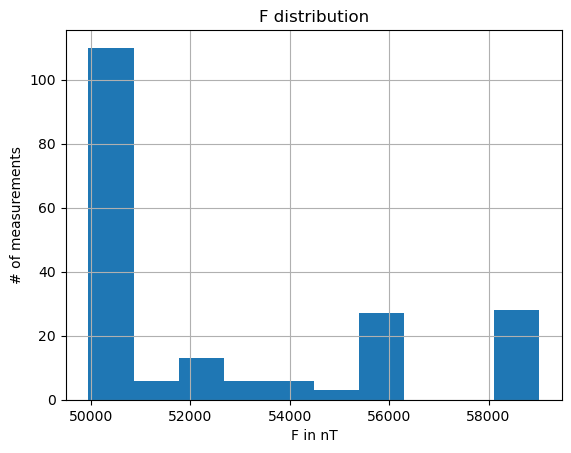

In [3]:
import matplotlib.pyplot as plt
## Creating a copy of the results and setting the Datetime Column as dataframe index.
ValidateDF = interpolated_df.copy()
ValidateDF.set_index("timestamp", inplace=True)
## Plotting the F column.
hist = ValidateDF.hist(column='F')
plt.title('F distribution')
plt.xlabel('F in nT')
plt.ylabel('# of measurements')